<a href="https://colab.research.google.com/github/KelvinLam05/sms_spam_detection/blob/main/sms_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Goal of the project**

In this notebook, we will build a simple, fast, and accurate English-language text classification model with minimal effort. More specifically, we will build a model that classifies text messages as either spam or ham (legitimate).

**Load the packages**

In [138]:
# Importing libraries
import pandas as pd
import numpy as np
import ktrain
import tensorflow as tf
from ktrain import text
from sklearn.model_selection import train_test_split

**Load the data**

For this project I’ve used the [SMS Spam Collection](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) dataset from Kaggle. This is a public set of SMS labeled messages that have been collected for mobile phone spam research.

In [139]:
# Load dataset
df = pd.read_csv('/content/sms_spam_collection.csv', encoding = 'latin-1')

In [140]:
df = df.dropna(how = 'any', axis = 1)

In [141]:
df.columns = ['label', 'message']

In [142]:
# Change the data frame's column names to lower case
df.columns= df.columns.str.lower()

In [143]:
# Examine the data
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [144]:
# Overview of all variables, their datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


**Check for missing values**

Before moving on, we will check to see if there are any null values to impute. However, the data were all fine, so there was nothing to do.

In [145]:
df.isnull().sum().sort_values(ascending = False)

label      0
message    0
dtype: int64

**Examine the data**

By running value_counts( ) on the label column containing our target variable, we can see that the data are imbalanced.

In [146]:
round(df['label'].value_counts(normalize = True) * 100)

ham     87.0
spam    13.0
Name: label, dtype: float64

**SMS message length**

Let's make a new column to detect how long the text messages are:

In [147]:
df['message_length'] = df['message'].apply(lambda x: len(x))

In [148]:
df['message_length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: message_length, dtype: float64

The maximum length of a text message is 910 characters. 

**Split the train and test data**

In [149]:
X = df.drop(['label'], axis = 1)

In [150]:
y = df['label']

In [151]:
# Stratified sampling based on the distribution of the target vector, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

**Encode target labels**

In [152]:
from sklearn.preprocessing import LabelEncoder

In [153]:
le = LabelEncoder()

In [154]:
y_train_enc = y_train.copy()

In [155]:
y_train_enc = pd.DataFrame(data = y_train_enc, columns = ['label'])

In [156]:
y_train_enc['label_encoded'] = le.fit_transform(y_train_enc['label'].values)

In [157]:
y_train_enc

,label,label_encoded
184,ham,0
2171,ham,0
5422,ham,0
4113,ham,0
4588,ham,0
...,...,...
1932,ham,0
5316,ham,0
2308,spam,1
1903,spam,1


In [158]:
# Label encode the target variable 
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

**Preprocess data and build a transformer model**

With the Transformer API in ktrain, we can select any Hugging Face transformers model appropriate for our data. Since we are dealing with SMS spam, we will use smaller BERT by the author mrm8488.


In [159]:
# Transformer model
MODEL_NAME = 'mrm8488/bert-tiny-finetuned-sms-spam-detection' 

We must supply a class_names argument to the Transformer constructor, which tells ktrain how indices map to class names. In this case, class_names = ['Non-spam', 'Spam'] because 0 = Non-spam, 1 = Spam.

In [160]:
t = text.Transformer(MODEL_NAME, maxlen = 512, class_names = ['ham', 'spam'])

In [161]:
# Convert training set into a list
X_tr = pd.DataFrame(data = X_train, columns = ['message'])
X_tr = X_tr['message'].tolist()

In [162]:
y_tr = pd.DataFrame(data = y_train, columns = ['label'])
y_tr = y_tr['label'].tolist()

In [163]:
# Convert testing set into a list
X_te = pd.DataFrame(data = X_test, columns = ['message'])
X_te = X_te['message'].tolist()

In [164]:
y_te = pd.DataFrame(data = y_test, columns = ['label'])
y_te = y_te['label'].tolist()

In [165]:
# Preprocessing training and testing set 
trn = t.preprocess_train(X_tr, y_tr)
val = t.preprocess_test(X_te, y_te)

preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 33
	99percentile : 52


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 16
	95percentile : 33
	99percentile : 56


In [ ]:
model = t.get_classifier()

In [167]:
# Wrap model and data in ktrain.Learner object
learner = ktrain.get_learner(model, train_data = trn, val_data = val, batch_size = 6)

**Estimate a good learning rate**

To train the model, we will first find the optimal learning rate that suits well to our problem. ktrain provides a very good method named lr_find which trains the model at different learning rates and plots loss of the model as the learning rate is increased.

In [168]:
# Briefly simulate training to find good learning rate
learner.lr_find(max_epochs = 3) 

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
742/742 [==============================] - 21s 22ms/step - loss: 0.1022 - accuracy: 0.9836
Epoch 2/3
742/742 [==============================] - 18s 24ms/step - loss: 0.2226 - accuracy: 0.9351
Epoch 3/3
742/742 [==============================] - 1s 1ms/step - loss: 0.7436 - accuracy: 0.7385


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


The learning rate plot can be observed by calling the following method:

Three possible suggestions for LR from plot:
	Longest valley (red): 1.85E-05
	Min numerical gradient (purple): 3.56E-05
	Min loss divided by 10 (omitted from plot): 3.77E-05


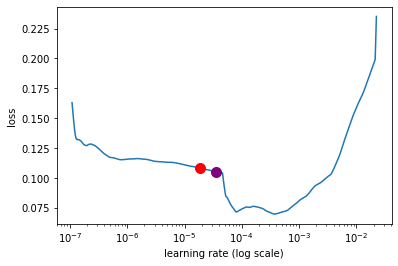

In [169]:
# Visually identify best learning rate
learner.lr_plot(suggest = True)

We will now train the model using the autofit method. The method trains the classifier and automatically selects the best performing one preventing underfitting and overfitting of the model.

In [170]:
# Training using the autofit policy
learner.autofit(1.85E-05, early_stopping = 5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 1.85e-05...
Epoch 1/1024
743/743 [==============================] - 23s 24ms/step - loss: 0.0819 - accuracy: 0.9856 - val_loss: 0.0657 - val_accuracy: 0.9857
Epoch 2/1024
743/743 [==============================] - 18s 24ms/step - loss: 0.0523 - accuracy: 0.9895 - val_loss: 0.0540 - val_accuracy: 0.9874
Epoch 3/1024
743/743 [==============================] - 18s 23ms/step - loss: 0.0432 - accuracy: 0.9901 - val_loss: 0.0513 - val_accuracy: 0.9865
Epoch 4/1024
743/743 [==============================] - 18s 23ms/step - loss: 0.0357 - accuracy: 0.9915 - val_loss: 0.0488 - val_accuracy: 0.9857
Epoch 5/1024
743/743 [==============================] - 19s 24ms/step - loss: 0.0308 - accuracy: 0.9919 - val_loss: 0.0437 - val_accuracy: 0.9892
Epoch 6/1024
743/743 [==============================] - 18s 23ms/step - loss: 0.0246 - accuracy: 0.9951 - val_loss: 0.0465 - val_accur

**Evaluate/Inspect model**

In [172]:
# Evaluate model
learner.validate(class_names = t.get_classes())

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       966
        spam       0.99      0.97      0.98       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.99      1115
weighted avg       0.99      0.99      0.99      1115



array([[965,   1],
       [  5, 144]])

Our spam filter with 0.99 precision and 0.97 recall has an F1 score of 0.98. 